In [1]:
# Import the required libraries

import dask.array as da
import os

from dask.distributed import Client, progress
from IPython.display import Image
from sklearn.datasets import make_classification
from sklearn.svm import SVC

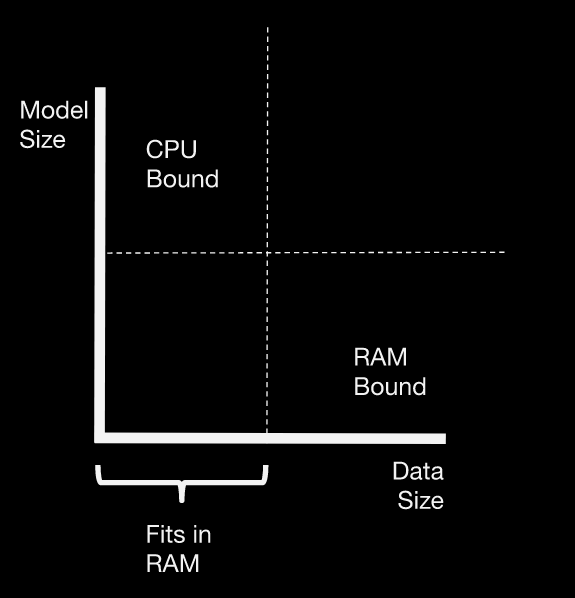

In [2]:
# Taxonomy of tasks that Dask is suitable for - CPU bound, RAM bound and CPU+RAM bound
Image(filename='images/ml-dimensions.png')

In [3]:
# Generate a dataset of 10,000 samples for classification for a CPU bound activity - Grid Search with cross validation
X, y = make_classification(n_samples=10000, n_features=4, random_state=0)
X[:8]

array([[-0.77244139,  0.3607576 , -2.38110133,  0.08757   ],
       [ 1.14946035,  0.62254594,  0.37302939,  0.45965795],
       [-1.90879217, -1.1602627 , -0.27364545, -0.82766028],
       [-0.77694695,  0.31434299, -2.26231851,  0.06339125],
       [-1.17047054,  0.02212382, -2.17376797, -0.13421976],
       [ 0.79010037,  0.68530624, -0.44740487,  0.44692959],
       [ 1.68616989,  1.6329131 , -1.42072654,  1.04050557],
       [-0.93912893, -1.02270838,  1.10093827, -0.63714432]])

In [4]:
# Lets fit a support vector classifier

from sklearn.model_selection import GridSearchCV

estimator = SVC(gamma='auto', random_state=0, probability=True)
# Setup the search space for the parameters
param_grid = {
    'C': [0.001, 10.0],
    'kernel': ['rbf', 'poly'],
}

# Multi-machine parallelism with Dask

In [5]:
import joblib
import dask.distributed

service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
print(service_host)

service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(f"{service_host}:{service_port}")

dask-6402b05659d2635c5c8d535f-dask-scheduler.domino-compute.svc.cluster.local


In [6]:
# Lets expand the search space for the C parameter and go with the default parameters for the other parameters
param_grid = {
    'C': [0.001, 0.1, 1.0, 2.5, 5, 10.0],
    # 'kernel': ['rbf', 'poly', 'linear'],
    # 'shrinking': [True, False],
}

grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=5, n_jobs=-1)

# Joblib works out of the box with Dask just set the backend as "dask"
with joblib.parallel_backend("dask", scatter=[X, y]):
    grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [7]:
# Print out the best parameters that were found
grid_search.best_params_, grid_search.best_score_

({'C': 10.0}, 0.9119000000000002)

# Example of a Pipeline, training on large dataset

In [8]:
print(X.shape)

import dask.array as da

# Create a large dataset to train on, eg of a RAM bound task

big_X = da.concatenate([
    da.from_array(X, chunks=X.shape)
    for _ in range(5)
])
big_X

(10000, 4)


dask.array<concatenate, shape=(50000, 4), dtype=float64, chunksize=(10000, 4), chunktype=numpy.ndarray>

In [9]:
big_y = da.concatenate([
    da.from_array(y, chunks=y.shape)
    for _ in range(5)
])
# big_y

In [10]:
%%time

from sklearn.pipeline import Pipeline
from dask_ml.decomposition import PCA

from dask_ml.linear_model import LogisticRegression
# Operations to conduct in a pipeline
estimators = [('reduce_dim', PCA()), ('logistic_regression', LogisticRegression())]

# Dask works well with the existing Python ecosystem so you can include Dask operations in an sklearn pipeline
pipe = Pipeline(estimators)
# Fit the model
pipe.fit(big_X, big_y)

CPU times: user 1.95 s, sys: 114 ms, total: 2.06 s
Wall time: 1min 1s


Pipeline(steps=[('reduce_dim', PCA()),
                ('logistic_regression', LogisticRegression())])

In [11]:
%%time
# Evaluate the fit model
print(pipe.score(big_X, big_y).compute())

0.8189
CPU times: user 34.7 ms, sys: 44 µs, total: 34.7 ms
Wall time: 294 ms


# Prediction on a large dataset

In [12]:
%%time

from sklearn.linear_model import LogisticRegressionCV
from dask_ml.wrappers import ParallelPostFit
import numpy as np
from sklearn.datasets import make_classification

# This does not parallelize the training step.
# It is helpful for situations where your training dataset is relatively small (fits on a single machine)
# but you need to predict or transform a much larger dataset
clf = ParallelPostFit(LogisticRegressionCV(cv=3), scoring="r2")
clf.fit(X, y)

CPU times: user 1.45 s, sys: 1.95 s, total: 3.4 s
Wall time: 3.39 s


ParallelPostFit(estimator=LogisticRegressionCV(cv=3), scoring='r2')

In [13]:
# Call the predict method on a large dataset
y_pred = clf.predict(big_X)

In [14]:
# The above statement is executed in a lazy fashion, the results are therefore not available immediately
y_pred

dask.array<_predict, shape=(50000,), dtype=int64, chunksize=(10000,), chunktype=numpy.ndarray>

In [15]:
# Execute the lazy evaluation
predictions = y_pred.compute()

In [16]:
predictions[0:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1])

# Xgboostclient on local cluster

In [17]:
# Dask integrates well with XGBoost and also offers the ability to spin up a local cluster so you can take advantage of
# multiple cores on a single machine

# Start a local cluster
client = Client(n_workers=4, threads_per_worker=1)
# See the details of the local client and cluster
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38333,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:46551,Total threads: 1
Dashboard: http://127.0.0.1:33273/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:36527,


In [18]:
from dask_ml.datasets import make_classification

# Create a dataset to be used to fit an XGBoost model
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    chunks=1000,
    n_informative=4,
    random_state=0,
)
X


dask.array<normal, shape=(10000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

In [19]:
from dask_ml.model_selection import train_test_split
# Split the dataset in to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [20]:
import xgboost as xgb

In [21]:
# Set the hyperparameters for XGBoost
params = {
    "objective": "binary:logistic",
    "max_depth": 4,
    "eta": 0.01,
    "subsample": 0.5, 
    "min_child_weight": 0.5,
    "eval_metric":'logloss'
}
# Create the datasets in a format that XGBoost can use to fit the model
dtrain = xgb.dask.DaskDMatrix(client, X, y)
# Fit the model
bst = xgb.dask.train(client, params, dtrain, num_boost_round=10)

[02:53:01] task [xgboost.dask]:tcp://127.0.0.1:32915 got new rank 0
[02:53:01] task [xgboost.dask]:tcp://127.0.0.1:34079 got new rank 1
[02:53:01] task [xgboost.dask]:tcp://127.0.0.1:34899 got new rank 2


In [22]:
# Check that the model exists
bst['booster']

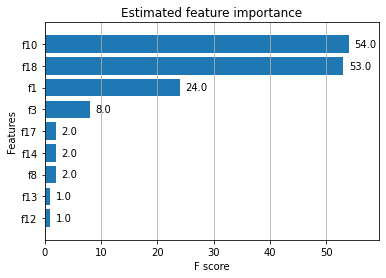

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
# Extract and plot the feature importance from the XGBoost model that was fit earlier
ax = xgb.plot_importance(bst['booster'], height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [24]:
# Get predictions from the XGBoost model
y_hat = xgb.dask.predict(client, bst, X_test)
y_hat

dask.array<mapped_predict, shape=(1500,), dtype=float32, chunksize=(150,), chunktype=numpy.ndarray>

In [25]:
import dask
from sklearn.metrics import roc_curve

# Plot the model accuracy metrics
y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

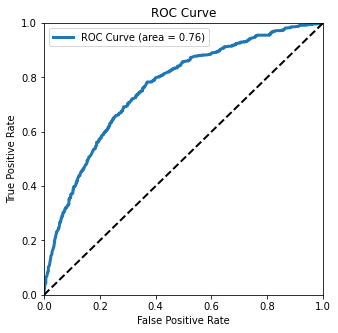

In [26]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

In [27]:
# Disconnect from the cluster
client.close()